# Data wrangling approach

Things to verify:
1. Are the 4 features(counts) useful as predictors or is it okay to throw them away?  

# Modeling Approach

1. Generate sliding windowed data set as before
2. Train test split as before
3. Unroll matrix at country of origin dimension and treat each sample differently
4. Standardize and log transform on just 1 feature
5. Model the spatio-temporal data on different baselines (minus graph data)

# Visualization approach

1. Model the diffusion on an actual world map?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import h5py
import gzip
import json
import os
import tqdm

import warnings

warnings.filterwarnings("ignore")

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.WARN)

## Load data

In [268]:
incidences = None
with h5py.File("data/EpiGCN/processing/incidences.hdf5", "r") as f:
    incidences = f['incidences'][:]

In [269]:
incidences.shape

(3181, 232, 366, 4)

### Normalize by population to get fraction of population infected

In [145]:
import json
countries_metadata = json.load(open('data/countries_metadata.json'))

In [141]:
with gzip.open('data/output_0000.h5.gz') as fp:
    f = h5py.File(fp,'r')
    compartments = f['dset'].attrs['Columns']
    country_ids = f['dset'].attrs['SelectedCountries']
    prevalence = np.array(f['dset/countries/cumulative'], dtype=np.int64)
    incidence = np.array(f['dset/countries/transitions'], dtype=np.int64)

In [142]:
country_ids

array([ 71, 140, 149, 222, 103, 183, 199,  53, 113,  29, 221, 207,  47,
        28, 213,  76, 157, 109, 181, 154, 164, 178,  50,  79, 108, 185,
         7,  31, 128,  91,  75, 227,  70,  80,  81,  12, 179, 176, 172,
       210,  94,  67, 200, 129, 218, 215, 110, 188,   2,  82, 187, 150,
        61, 177, 119,  16, 180,  95, 208, 147,  54,  86,  15,  88,  60,
        90, 158, 230,  58,   8, 144,  89, 202, 130, 104, 138,  10,  13,
       161,  35, 193, 111, 229,  72,  48, 153,   5,  84, 117,  22, 191,
       112,  73, 120, 214, 107,  62, 116,  85,   0, 206, 115,  34,  25,
        45, 160, 205,  49,  78, 159,  63, 106, 201, 125, 216, 122, 134,
         3,  52, 223,  43, 123,  41,  51, 135, 169, 101, 197,  39, 139,
         1,  27,  55,  83,  23,   6,  65, 190,  74, 231, 145, 196, 211,
       141,  32, 121, 155, 137, 114,  19,  99, 146,  11, 136, 220, 195,
       105, 170, 219,  98, 203, 217, 173,  64, 228, 127, 212,  42, 156,
       192, 182,  46,  59,  18, 102,  36, 168,  26,  87, 126, 12

In [143]:
def get_countries_population(country_ids, countries_metadata):
    """
    countries are ordered using country ids, we query for their population and return it accordingly.
    """
    return np.array(
        list(map(lambda cid: countries_metadata[str(cid)]["population"], country_ids))
    )

In [146]:
countries_population = get_countries_population(country_ids, countries_metadata)

In [12]:
incidences = (incidences / countries_population[np.newaxis, :, np.newaxis, np.newaxis])

In [13]:
print("min", incidences.min())
print("max", incidences.max())
print("mean", incidences.mean())
print("std", incidences.std())

min 0.0
max 0.04334470989761092
mean 0.0009119511804321677
std 0.0023550459485025665


Now that incidences is (hopefully) normalized by population, we can use sliding windows and create train test sets

In [15]:
with h5py.File('data/EpiGCN/processing/incidences_normalized.hdf5', 'w') as f:
    f.create_dataset('incidences', data=incidences, compression="lzf")

## Load incidences normalized

In [60]:
incidences_normalized = None
with h5py.File("data/EpiGCN/processing/incidences_normalized.hdf5", "r") as f:
    incidences_normalized = f['incidences'][:]

## Create sliding window dataset

In [61]:
incidences_normalized.shape

(3181, 232, 366, 4)

In [24]:
from IPython.display import clear_output

def generate_sliding_windows_dataset(incidences, t_lag=10, window_size=10):
    """
    :t_lag: 
    :window_size: assumes this is less than 366
    """
    with h5py.File("data/EpiGCN/dataset.hdf5", "w") as fw:
        x_ts = fw.create_dataset(
            "x_ts",
            compression="lzf",
            shape=((366 - t_lag - window_size + 1) * 3181, 232, window_size, 4),
            maxshape=(None, 232, window_size, 4),
        )
        y_ts = fw.create_dataset(
            "y_ts",
            compression="lzf",
            shape=((366 - t_lag - window_size + 1) * 3181, 232, 1, 4),
            maxshape=(None, 232, 1, 4),
        )

        start, end = t_lag + window_size, 367
        window_indices = np.arange(start, end, step=1)
        target_ix = 0
        for ix in list(reversed(window_indices)):
            print(ix, target_ix)
            
            x = incidences[:, :, (ix - window_size) : ix, :]
            y = incidences[:, :, (ix - window_size - t_lag), :]

            ## expand dims for y so that there is a single dimension for y
            ## and then swap last 2 axis so that counts are again the last axis
            y = np.swapaxes(np.expand_dims(y, -1), -1, -2)
            x_ts[target_ix * 3181: (target_ix + 1) * 3181] = x
            y_ts[target_ix * 3181: (target_ix + 1) * 3181] = y
            target_ix += 1
            clear_output(wait=True)
        #     return np.stack(x_data), np.stack(y_data)

In [25]:
generate_sliding_windows_dataset(incidences_normalized)

20 346


In [27]:
with h5py.File("data/EpiGCN/dataset.hdf5", "r") as f:
    print(f['x_ts'].shape)
    print(f['y_ts'].shape)

(1103807, 232, 10, 4)
(1103807, 232, 1, 4)


## Split into train and test

In [2]:
def get_train_val_test_indices(t_lag=10, window_size=10, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    rng = np.random.RandomState(random_seed)
    num_samples = (366 - t_lag - window_size + 1) * 3181
    indices = list(range(num_samples))
    rng.shuffle(indices)
    train_ratio = 1 - val_ratio - test_ratio
    train, validate, test = np.split(indices, [int(train_ratio*len(indices)), int((train_ratio + val_ratio)*len(indices))])
    return train, validate, test

In [4]:
train_indices, val_indices, test_indices = get_train_val_test_indices()
print("Training size:", len(train_indices))
print("Val size:", len(val_indices))
print("Test size:", len(test_indices))

Training size: 883045
Val size: 110381
Test size: 110381


In [5]:
x_ts = None
y_ts = None

with h5py.File("data/EpiGCN/dataset.hdf5", "r") as f:
    x_ts = f["x_ts"][:]
    y_ts = f["y_ts"][:]

This loads the entire dataset in memory - approx 50 GB and splits into train test

In [6]:
def split_into_train_test_in_mem(train_indices, val_indices, test_indices):
    x_train, y_train = x_ts[train_indices], y_ts[train_indices]
    x_test, y_test = x_ts[test_indices], y_ts[test_indices]
    x_val, y_val = x_ts[val_indices], y_ts[val_indices]
    
    print("finished splitting")
    for cat in ['train', 'val', 'test']:
        _x, _y = locals()["x_" + cat], locals()["y_" + cat]
        with h5py.File('data/EpiGCN/{}.hdf5'.format(cat), 'w') as f:
            f.create_dataset('x', data=_x, compression="lzf")
            f.create_dataset('y', data=_y, compression="lzf")

In [8]:
split_into_train_test_in_mem(train_indices, val_indices, test_indices)

finished splitting


In [10]:
for cat in ['train', 'val', 'test']:
    with h5py.File('data/EpiGCN/{}.hdf5'.format(cat), 'r') as f:
        print("X: ", f['x'].shape, 'y: ',f['y'].shape)

X:  (883045, 232, 10, 4) y:  (883045, 232, 1, 4)
X:  (110381, 232, 10, 4) y:  (110381, 232, 1, 4)
X:  (110381, 232, 10, 4) y:  (110381, 232, 1, 4)


This method allows streaming train test split of the data

In [11]:
# def split_into_train_test(train_incides, test_indices, window_size=10):
#     with h5py.File("data/EpiGCN/dataset.hdf5", "r") as f:
#         with h5py.File("data/EpiGCN/train_test.hdf5", "w") as fw:
#             x_ts = f["x_ts"][:]
#             print("x data loaded")

#             y_ts = f["y_ts"][:]

#             print("y data loaded")

#             x_train = fw.create_dataset(
#                 "x_train",
#                 compression="lzf",
#                 shape=(len(train_indices), 232, window_size, 4),
#                 maxshape=(None, 232, window_size, 4),
#             )
#             y_train = fw.create_dataset(
#                 "y_train",
#                 compression="lzf",
#                 shape=(len(train_indices), 232, 1, 4),
#                 maxshape=(None, 232, 1, 4),
#             )
#             x_test = fw.create_dataset(
#                 "x_test",
#                 compression="lzf",
#                 shape=(len(test_indices), 232, window_size, 4),
#                 maxshape=(None, 232, window_size, 4),
#             )
#             y_test = fw.create_dataset(
#                 "y_test",
#                 compression="lzf",
#                 shape=(len(test_indices), 232, 1, 4),
#                 maxshape=(None, 232, 1, 4),
#             )

#             train_current_ix, test_current_ix = 0, 0
#             batch_size = 5000
#             for ix in range(0, len(train_indices), batch_size):
#                 print(
#                     "Training progress: {:.2f}".format(
#                         (train_current_ix * batch_size * 1.0) / len(train_incides)
#                     )
#                 )
#                 ixes = sorted(train_indices[ix : ix + batch_size])
#                 x_train[ix : ix + batch_size] = x_ts[ixes]
#                 y_train[ix : ix + batch_size] = y_ts[ixes]
#                 train_current_ix += 1
#                 clear_output(wait=True)

#             for test_ix in tqdm.tqdm_notebook(test_indices):
#                 print(
#                     "Testing progress: {:.2f}".format(
#                         (test_current_ix * 1.0) / len(test_indices)
#                     )
#                 )
#                 x_test[test_current_ix] = x_ts[test_ix]
#                 y_test[test_current_ix] = y_ts[test_ix]
#                 test_current_ix += 1
#                 clear_output(wait=True)

In [18]:
# split_into_train_test(train_indices, test_indices)

In [ ]:
x_train = None
y_train = None
x_test = None
y_test = None
x_val = None
y_val = None

with h5py.File('data/EpiGCN/train.hdf5', 'r') as f:
    x_train = f['x'][:] 
    y_train = f['y'][:]

with h5py.File('data/EpiGCN/val.hdf5', 'r') as f:
    x_val = f['x'][:] 
    y_val = f['y'][:]
    
with h5py.File('data/EpiGCN/test.hdf5', 'r') as f:
    x_test = f['x'][:] 
    y_test = f['y'][:]

In [ ]:
print("y test size", y_test.shape)

In [ ]:
x_train.shape

# Define Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

# Define Dataloader

In [ ]:
# params = {"batch_size": 12, "shuffle": True, "num_workers": 4}

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=12)

## Model definition

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
class BaselineLSTM(nn.Module):
    def __init__(self, num_nodes, input_dim, rnn_dim, num_layers=1):
        super(BaselineLSTM, self).__init__()
        self.num_layers = num_layers
        hidden_size = num_nodes*rnn_dim
        input_size = num_nodes*input_dim
        self.lstm = nn.LSTM(
            input_size=num_nodes*input_dim,
            hidden_size=num_nodes*rnn_dim,
            batch_first=True,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(hidden_size * num_layers, input_size)

    def forward(self, lstm_input):
        b, n_countries, seq_len, n_compartments = lstm_input.size()
        lstm_input = lstm_input.permute(0, 2, 1, 3)
        _, (hn, _) = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
        hn = hn.permute(1, 0, 2)
        return self.linear(hn.reshape(b, -1)).view(b, n_countries, 1, n_compartments)


class BaselineGRU(nn.Module):
    def __init__(self, num_nodes, input_dim, rnn_dim, num_layers=1):
        super(BaselineGRU, self).__init__()
        self.num_layers = num_layers
        hidden_size = num_nodes*rnn_dim
        input_size = num_nodes*input_dim
        self.lstm = nn.GRU(
            input_size=num_nodes*input_dim,
            hidden_size=num_nodes*rnn_dim,
            batch_first=True,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(hidden_size * num_layers, input_size)

    def forward(self, lstm_input):
        b, n_countries, seq_len, n_compartments = lstm_input.size()
        lstm_input = lstm_input.permute(0, 2, 1, 3)
        _, hn = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
        hn = hn.permute(1, 0, 2)
        return self.linear(hn.reshape(b, -1)).view(b, n_countries, 1, n_compartments)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Loss
from ignite.contrib.handlers.tensorboard_logger import *
import wandb


class ModelTrainer:
    def __init__(self, run_name, **training_params):
        self.run_name = run_name
        self.training_params = training_params

        params_str = ",".join(
            ["{}={}".format(k, v) for k, v in training_params.items()]
        )
        self.param_str = "{}_{}".format(run_name, params_str)
        wandb.init(sync_tensorboard=True, name=self.param_str)
        wandb.config.initial_lr = training_params["lr"]
        wandb.config.num_nodes = training_params["num_nodes"]
        wandb.config.input_dim = training_params["input_dim"]
        wandb.config.rnn_dim = training_params["rnn_dim"]
        wandb.config.num_layers = training_params["num_layers"]
        wandb.config.param_str = self.param_str

    def train(self, model_class, max_epochs=100, **kwargs):
        model_args = kwargs.get("model", {})
        model = model_class(
            num_nodes=self.training_params["num_nodes"],
            input_dim=self.training_params["input_dim"],
            rnn_dim=self.training_params["rnn_dim"],
            num_layers=self.training_params["num_layers"],
            **model_args
        )

        wandb.watch(model)

        optimizer = torch.optim.Adam(model.parameters(), lr=self.training_params["lr"])
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, factor=0.5
        )

        mse = torch.nn.MSELoss()
        mae = torch.nn.L1Loss()

        tb_logger = TensorboardLogger(
            log_dir="experiments/tb_logs/runs/{}".format(self.param_str)
        )

        trainer = create_supervised_trainer(model, optimizer, mae, device=device)

        metrics = {"mae": Loss(mae), "mse": Loss(mse)}

        train_evaluator = create_supervised_evaluator(
            model, metrics=metrics, device=device
        )
        val_evaluator = create_supervised_evaluator(
            model, metrics=metrics, device=device
        )
        test_evaluator = create_supervised_evaluator(
            model, metrics=metrics, device=device
        )

        def score_function(trainer):
            val_evaluator.run(val_dataloader)
            metrics = val_evaluator.state.metrics
            mae = metrics["mae"]
            return -mae

        checkpointer = ModelCheckpoint(
            "model_checkpoints",
            self.param_str,
            score_function=score_function,
            score_name="mae",
            n_saved=2,
            create_dir=True,
            save_as_state_dict=True,
            require_empty=False,
        )

        trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {"epi": model})

        tb_logger.attach(
            trainer,
            log_handler=OutputHandler(
                tag="training", output_transform=lambda loss: {"loss": loss}
            ),
            event_name=Events.ITERATION_COMPLETED,
        )

        tb_logger.attach(
            train_evaluator,
            log_handler=OutputHandler(
                tag="training",
                metric_names=["mae", "mse"],
                global_step_transform=global_step_from_engine(trainer),
            ),
            event_name=Events.EPOCH_COMPLETED,
        )

        tb_logger.attach(
            val_evaluator,
            log_handler=OutputHandler(
                tag="validation",
                metric_names=["mae", "mse"],
                global_step_transform=global_step_from_engine(trainer),
            ),
            event_name=Events.EPOCH_COMPLETED,
        )

        tb_logger.attach(
            test_evaluator,
            log_handler=OutputHandler(
                tag="test",
                metric_names=["mae", "mse"],
                global_step_transform=global_step_from_engine(trainer),
            ),
            event_name=Events.EPOCH_COMPLETED,
        )

        # Attach the logger to the trainer to log optimizer's parameters, e.g. learning rate at each iteration
        tb_logger.attach(
            trainer,
            log_handler=OptimizerParamsHandler(optimizer),
            event_name=Events.ITERATION_STARTED,
        )

        # Attach the logger to the trainer to log model's weights norm after each iteration
        tb_logger.attach(
            trainer,
            log_handler=WeightsScalarHandler(model),
            event_name=Events.ITERATION_COMPLETED,
        )

        # Attach the logger to the trainer to log model's weights as a histogram after each epoch
        tb_logger.attach(
            trainer,
            log_handler=WeightsHistHandler(model),
            event_name=Events.EPOCH_COMPLETED,
        )

        # Attach the logger to the trainer to log model's gradients norm after each iteration
        tb_logger.attach(
            trainer,
            log_handler=GradsScalarHandler(model),
            event_name=Events.ITERATION_COMPLETED,
        )

        # Attach the logger to the trainer to log model's gradients as a histogram after each epoch
        tb_logger.attach(
            trainer,
            log_handler=GradsHistHandler(model),
            event_name=Events.EPOCH_COMPLETED,
        )

        @trainer.on(Events.ITERATION_COMPLETED)
        def log_training_loss(trainer):
            logger.info(
                "Epoch[{}] Loss: {:.7f}".format(
                    trainer.state.epoch, trainer.state.output
                )
            )
            wandb.log({"train loss": trainer.state.output})

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(trainer):
            train_evaluator.run(train_dataloader)
            metrics = train_evaluator.state.metrics
            logger.info(
                "Training Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
                    trainer.state.epoch, metrics["mse"], metrics["mae"]
                )
            )

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_validation_results(trainer):
            val_evaluator.run(val_dataloader)
            metrics = val_evaluator.state.metrics
            logger.info(
                "Validation Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
                    trainer.state.epoch, metrics["mse"], metrics["mae"]
                )
            )
            lr_scheduler.step(metrics["mae"])
            wandb.log({"val mae": metrics["mae"]})
            wandb.log({"val mse": metrics["mse"]})

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_test_results(trainer):
            test_evaluator.run(test_dataloader)
            metrics = test_evaluator.state.metrics
            logger.info(
                "Test Results - Epoch: {} MSE: {:.7f} MAE: {:.7f}".format(
                    trainer.state.epoch, metrics["mse"], metrics["mae"]
                )
            )
            lr_scheduler.step(metrics["mae"])
            wandb.log({"test mae": metrics["mae"]})
            wandb.log({"test mse": metrics["mse"]})

        trainer.run(train_dataloader, max_epochs=max_epochs)
        tb_logger.close()

In [305]:
trainer = ModelTrainer('IID_LSTM', num_nodes=232, input_dim=4, rnn_dim=10, num_layers=3, lr=1e-3)
trainer.train(BaselineLSTM)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
ERROR:ignite.engine.engine.Engine:Current run is terminating due to exception: .
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: .


KeyboardInterrupt: 

ERROR:wandb.apis.internal:404 response executing GraphQL.
ERROR:wandb.apis.internal:{"errors":[{"message":"run chnsh/epigcn/4h472gr2 not found during upsertBucket","path":["upsertBucket"]}],"data":{"upsertBucket":null}}
wandb: ERROR Error while calling W&B API: run chnsh/epigcn/4h472gr2 not found during upsertBucket (<Response [404]>)
Exception in thread Thread-308:
Traceback (most recent call last):
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/wandb/retry.py", line 95, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/wandb/apis/internal.py", line 116, in execute
    six.reraise(*sys.exc_info())
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/six.py", line 693, in reraise
    raise value
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/wandb/apis/internal.py", line 110, in execute
    return self.client.execute(*args, **kwargs)
  F

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7f645c086ef0> (for post_run_cell):


CommError: Permission denied to access chnsh/epigcn/4h472gr2

Exception in thread Thread-302:
Traceback (most recent call last):
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/wandb/apis/file_stream.py", line 219, in _thread_body
    self._endpoint, json={'complete': False, 'failed': False}))
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/wandb/apis/file_stream.py", line 227, in _handle_response
    raise response
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/wandb/util.py", line 564, in request_with_retry
    response.raise_for_status()
  File "/home/chintan/miniconda3/envs/epigcn/lib/python3.7/site-packages/requests/models.py", line 940, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests

In [53]:
trainer = ModelTrainer('IID_GRU', num_nodes=232, input_dim=4, rnn_dim=4, num_layers=3, lr=1e-3)
trainer.train(BaselineGRU)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: WARNING Not logging key "IID_GRU_input_size=928,hidden_size=400,num_layers=3,lr=0.001/weights/lstm/weight_ih_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "IID_GRU_input_size=928,hidden_size=400,num_layers=3,lr=0.001/weights/lstm/weight_hh_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "IID_GRU_input_size=928,hidden_size=400,num_layers=3,lr=0.001/weights/lstm/bias_ih_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "IID_GRU_input_size=928,hidden_size=400,num_layers=3,lr=0.001/weights/lstm/bias_hh_l0".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "IID_GRU_input_size=928,hidden_size=400,num_layers=3,lr=0.001/weights/lstm/weight_ih_l1".  Histograms must have fewer than 512 bins
wandb: WARNING Not logging key "IID_GRU_input_size=928,hidde

# Diagnostics and visualizations

We now have trained models, we should try and reconstruct predictions of actual data. The issue with our transformed data set is that our samples are now IID (and hence shuffled on the time axis) and therefore we need to reconstruct a diagnosis dataset that is not shuffled on the time axis

In [220]:
class DiagnosisConstructor:
    def __init__(self, trained_model, normalized_dataset_for_origin, countries_population):
        """
        Takes a trained model and dataset for 1 particular place of origin.
        """
        assert(normalized_dataset_for_origin.shape==(232,366,4))
        self.trained_model = trained_model.eval()
        self.normalized_dataset = normalized_dataset_for_origin
        self.countries_population = countries_population
    
    def construct_dataset(self, t_lag=10, window_size=10):
        """
        t_lag and window_size should ideally be stored with model 
        metadata and retrieved to reconstruct the data set.
        """
        start, end = t_lag + window_size, 367
        window_indices = np.arange(start, end, step=1)
        x_ts = []
        y_ts = []
        for ix in list(reversed(window_indices)):
            x = self.normalized_dataset[:, (ix - window_size) : ix, :]
            y = self.normalized_dataset[:, (ix - window_size - t_lag), :]

            ## expand dims for y so that there is a single dimension for y
            ## and then swap last 2 axis so that counts are again the last axis
            y = np.swapaxes(np.expand_dims(y, -1), -1, -2)
            x_ts.append(x)
            y_ts.append(y)
        #we need expand dims to create the batch dimension
        return np.stack(x_ts), np.stack(y_ts)
    
    def truth_and_predictions_from_model(self):
        x, y = self.construct_dataset()
        dataset = TensorDataset(torch.FloatTensor(x), torch.FloatTensor(y))
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
        
        predictions = []
        truths = []
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                logits = self.trained_model(batch_x)
                predictions.append(logits.cpu())
                truths.append(batch_y.cpu())
        truths, predictions = np.concatenate(truths), np.concatenate(predictions)
        unnormalized_truths, unnormalized_preds = truths * self.countries_population[np.newaxis, :, np.newaxis, np.newaxis], predictions * self.countries_population[np.newaxis, :, np.newaxis, np.newaxis]
        return truths, predictions, unnormalized_truths, unnormalized_preds

In [221]:
trained_model = BaselineGRU(input_size=232*4, hidden_size=400, num_layers=3)

In [222]:
trained_model.load_state_dict(
    torch.load(
        "model_checkpoints/IID_GRU_input_size=928,hidden_size=400,num_layers=3,lr=0.001_epi_100_mae=9.694148e-05.pth"
    )
)

<All keys matched successfully>

In [259]:
diagnostics_constructor = DiagnosisConstructor(trained_model, incidences_normalized[100], countries_population)

In [260]:
truths, preds, unnormalized_truths, unnormalized_preds = diagnostics_constructor.truth_and_predictions_from_model()

In [261]:
preds.shape

(347, 232, 1, 4)

## Line visualization

Line visualization attempts to visualize predictions of a model (of 4 comparments)

In [262]:
class LineVisualizer:
    def __init__(self, y_true, y_pred, comparment_names=None):
        self.y_true = y_true
        self.y_pred = y_pred
        self.compartment_names = comparment_names
        
    def plot(self, country_ix=0):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Temporal Predictions for country: {}'.format(country_ix))
        for row_ix, row in enumerate(axes):
            for ix, ax in enumerate(row):
                compartment = (row_ix * len(row)) + ix
                ax.set_title(self.compartment_names[compartment])
                ax.plot(self.y_true[:, country_ix, :, compartment], label='Truth')
                ax.plot(self.y_pred[:, country_ix, :, compartment], label='Predictions')
                ax.legend()

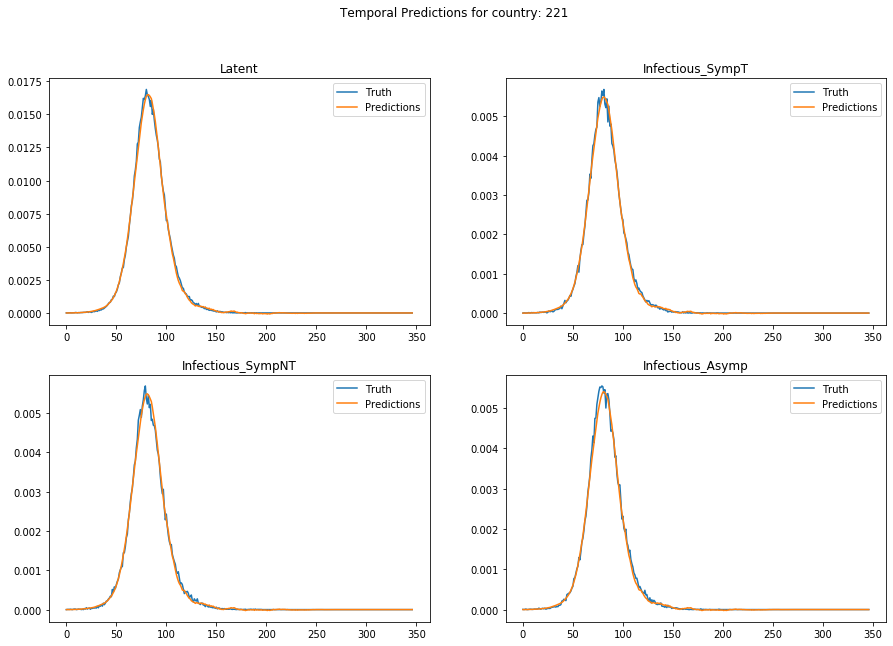

In [272]:
LineVisualizer(truths, preds, compartments).plot(221)

# PyTorch Geometric Implementation

PyTorch Geometric requires the graph data to be setup in a particular way. 

See https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html for reference.

Also https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

### Step 1. Setup graph dataset

In [276]:
import torch
from torch_geometric.data import Data

def setup_geometric_data(adj_mx):
    """
    Sets up data for PyTorch Geometric
    """
    edge_index = []
    edge_weights = []
    for row_ix, row in enumerate(adj_mx):
        for col_ix, weight in enumerate(row):
            if weight > 0:
                edge_index.append([row_ix, col_ix])
                edge_weights.append(weight)
    
    edge_index = torch.LongTensor(edge_index).t().contiguous()
    edge_weights = torch.FloatTensor(edge_weights)
    return Data(edge_index=edge_index, edge_weights=edge_weights)

### Step 2. Model implementation

The following model has 2 GCN modules - one for input and one for hidden

In [ ]:
class BaselineGConvNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, **kwargs):
        super(BaselineGConvNet, self).__init__()
        """
        multiple layers not implemented yet!
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.geometric_data = geometric_data.to(device) #moving to device
        self.input_gconv = GCNConv(input_size, input_size)
        self.hidden_gconv = GCNConv(hidden_size, hidden_size)
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size * num_layers, input_size) 
    
    def forward(self, gru_input):
        edge_index, edge_weights = self.geometric_data.edge_index, self.geometric_data.edge_weights
        b, n_countries, seq_len, n_compartments = gru_input.size()
        hn = torch.zeros(b, self.hidden_size, device=device)
        for t in range(seq_len):
            t_input = self.input_gconv(gru_input[:,:, t, :].contiguous().view(b, -1), edge_index, edge_weights)
            t_hn = self.hidden_gconv(hn, edge_index, edge_weights)
            hn = self.gru(t_input, t_hn)
        return self.linear(hn).view(b, n_countries, 1, n_compartments)

The following module has 2 GCN modules (2 layers) which acts as the GCNCell

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import math

# class GConvOp(torch.nn.Module):
#     def __init__(self, num_nodes, input_dim, rnn_dim, geometric_data):
#         super(GConvOp, self).__init__()
#         self.num_nodes = num_nodes
#         self.input_dim = input_dim
#         self.rnn_dim = rnn_dim
#         self.geometric_data = geometric_data.to(device)
#         self.gconv_1 = GCNConv(num_nodes * (input_dim + rnn_dim), 2 * num_nodes * (input_dim + rnn_dim))
#         self.gconv_2 = GCNConv(2 * num_nodes * (input_dim + rnn_dim), num_nodes * (input_dim + rnn_dim))

#     def forward(self, gru_input, hidden_state):
#         """
#         :gru_input: (b, num_nodes * input_dim)
#         :hidden_state: (b, num_nodes * rnn_dim)
#         """
#         b = gru_input.size(0)
#         edge_index, edge_weights = self.geometric_data.edge_index, self.geometric_data.edge_weights
#         input_and_state = torch.cat((gru_input, hidden_state), dim=-1)
#         x = self.gconv_1(input_and_state.view(b, -1), edge_index, edge_weights)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.gconv_2(x, edge_index, edge_weights)
#         inp_slice = self.input_dim * self.num_nodes
#         hidden_slice = self.rnn_dim * self.num_nodes
#         gru_input, hidden_state = torch.split(x.view(b, -1), (inp_slice, hidden_slice), dim=-1)
#         return gru_input, hidden_state


# class GConvOpInputOnly(torch.nn.Module):
#     def __init__(self, num_nodes, input_dim, geometric_data):
#         super(GConvOpInputOnly, self).__init__()
#         self.num_nodes = num_nodes
#         self.input_dim = input_dim
#         self.geometric_data = geometric_data.to(device)
#         self.gconv_1 = GCNConv(num_nodes * (input_dim), 2 * num_nodes * (input_dim))
#         self.gconv_2 = GCNConv(2 * num_nodes * (input_dim), num_nodes * (input_dim))

#     def forward(self, gru_input):
#         """
#         :gru_input: (b, num_nodes * input_dim)
#         :hidden_state: (b, num_nodes * rnn_dim)
#         """
#         b = gru_input.size(0)
#         edge_index, edge_weights = self.geometric_data.edge_index, self.geometric_data.edge_weights
#         x = self.gconv_1(gru_input, edge_index, edge_weights)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.gconv_2(x, edge_index, edge_weights)
#         return x


class GConvOpInputOnly(torch.nn.Module):
    def __init__(self, num_nodes, input_dim, normalized_adj_mx, hidden_dim=16):
        super(GConvOpInputOnly, self).__init__()
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.normalized_adj_mx = normalized_adj_mx.to(device)
        self.inp_to_hidden = nn.Parameter(torch.Tensor(input_dim, input_dim))
        #         self.hidden_to_op = nn.Parameter(torch.Tensor(hidden_dim, input_dim))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.inp_to_hidden, a=math.sqrt(5))

    #         torch.nn.init.kaiming_uniform_(self.hidden_to_op, a=math.sqrt(5))

    def forward(self, gru_input):
        """
        :gru_input: (b, num_nodes, input_dim)
        """
        x = torch.matmul(self.normalized_adj_mx, gru_input)
        x = torch.matmul(x, self.inp_to_hidden)
        x = F.relu(x)
        #         x = F.dropout(x, training=self.training)
        #         x = torch.matmul(self.normalized_adj_mx, x)
        #         return torch.matmul(x, self.hidden_to_op)
        return x


class GConvGRU(torch.nn.Module):
    def __init__(self, num_nodes, input_dim, rnn_dim, num_layers=1, **kwargs):
        super(GConvGRU, self).__init__()
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.input_size = num_nodes * input_dim
        self.hidden_size = num_nodes * rnn_dim
        #         self.gconv_op = GConvOp(num_nodes, input_dim, rnn_dim, geometric_data=geometric_data)
        #         self.gconv_op = GConvOpInputOnly(num_nodes, input_dim, geometric_data=geometric_data)
#         normalized_adj_mx = torch.FloatTensor(normalized_adj_mx, device=device)
        self.gconv_l0_op = GConvOpInputOnly(
            num_nodes, input_dim, normalized_adj_mx=torch.FloatTensor(normalized_adj_mx)
        )
        self.gconv_l1_op = GConvOpInputOnly(
            num_nodes, rnn_dim, normalized_adj_mx=torch.FloatTensor(normalized_adj_mx)
        )
        self.gru_list = [nn.GRUCell(self.input_size, self.hidden_size)] + [nn.GRUCell(self.hidden_size, self.hidden_size) for _ in range(num_layers)]
        self.gru_list = nn.ModuleList(self.gru_list)
        self.linear = nn.Linear(self.hidden_size * num_layers, self.input_size)

    def forward(self, gru_input):
        b, n_countries, seq_len, n_compartments = gru_input.size()
        gconv_op = self.gconv_l0_op
        layer_inputs = gru_input
        last_t_hidden_states = []

        for layer_ix in range(self.num_layers):
            gru = self.gru_list[layer_ix]
            hn = torch.zeros(b, self.hidden_size, device=device)
            hidden_states = []

            for t in range(seq_len):
                t_input = gconv_op(layer_inputs[:, :, t, :].contiguous())
                hn = gru(t_input.view(b, -1), hn)
                hidden_states.append(
                    hn.view(b, self.num_nodes, -1)
                )  # (b, num_nodes, rnn_dim)

            last_t_hidden_states.append(hn)
            gconv_op = self.gconv_l1_op

            hidden_states = torch.stack(
                hidden_states
            )  # (seq_len, b, num_nodes, rnn_dim)
            layer_inputs = hidden_states.permute(1, 2, 0, 3)

        last_t_hidden_states = torch.stack(last_t_hidden_states).permute(
            1, 0, 2
        )  # (b, num_layers, hidden_size)
        return self.linear(last_t_hidden_states.contiguous().view(b, -1)).view(b, n_countries, 1, n_compartments)
    

class GConvMultiLayerGRU(nn.Module):
    def __init__(self, num_nodes, input_dim, rnn_dim, num_layers=1):
        super(GConvMultiLayerGRU, self).__init__()
        self.gconv = GConvOpInputOnly(
            num_nodes, input_dim, normalized_adj_mx=torch.FloatTensor(normalized_adj_mx)
        )
        self.hidden_size = num_nodes*rnn_dim
        self.input_size = num_nodes*input_dim
        self.num_layers = num_layers
        self.lstm = nn.GRU(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            batch_first=True,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(self.hidden_size * num_layers, self.input_size)

    def forward(self, lstm_input):
        b, n_countries, seq_len, n_compartments = lstm_input.size()
        for t in range(seq_len):
            lstm_input[:, :, t, :] = self.gconv(lstm_input[:, :, t, :].contiguous())
        lstm_input = lstm_input.permute(0, 2, 1, 3)
        _, hn = self.lstm(lstm_input.contiguous().view(b, seq_len, -1))
        hn = hn.permute(1, 0, 2)
        return self.linear(hn.reshape(b, -1)).view(b, n_countries, 1, n_compartments)

In [ ]:
import scipy.sparse as sp
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj_normalized.todense()

In [ ]:
adj_mx = np.load('data/EpiGCN/adj_mx_raw.npy')
# geometric_data = setup_geometric_data(adj_mx=adj_mx)
normalized_adj_mx = preprocess_adj(adj_mx)

In [ ]:
# trainer = ModelTrainer('IID_GRU', num_nodes=232, input_dim=4, rnn_dim=10, num_layers=3, lr=1e-4)
# trainer.train(BaselineGRU)

In [ ]:
trainer = ModelTrainer('GConvMultiLayerGRU', num_nodes=232, input_dim=4, rnn_dim=10, num_layers=3, lr=1e-4)
trainer.train(GConvMultiLayerGRU)